In [32]:
import pandas as pd
import numpy as np
from glob import glob
import bagpipes as pipes
def load_pivot_wave(version,):
    stack_df = pd.read_csv(f'/home/lupengjun/OII_emitter/photometry/output/flux_sum_{version}.csv', index_col=0).stack().reset_index()
    filters = stack_df['level_0']
    telescopes = stack_df['level_1']
    filter_list = [glob(f'/home/lupengjun/OII_emitter/data/filter/{telescope}/*{band}*')[0] for telescope, band in zip(telescopes, filters)]
    filter_set = pipes.filters.filter_set(filter_list)
    return filter_set.eff_wavs
def load_fluxes(version,):
    fluxes = pd.read_csv(f'/home/lupengjun/OII_emitter/photometry/output/flux_sum_{version}.csv', index_col=0).stack().values
    # errors = pd.read_csv(f'/home/lupengjun/OII_emitter/photometry/output/error_sum_{version}.csv', index_col=0).drop(drop_telescope, axis=1).drop(drop_band, axis=0).stack().values
    # photometry = np.c_[fluxes, errors]
    return fluxes


In [22]:
def get_Av(source_position):
    '''
    get the extinction value of the source position from MWdust map
    source position is a SkyCoord object
    '''
    import mwdust
    #transform equatorial coordinate to galactic coordinate
    source_position_ = source_position.transform_to('galactic')
    l = source_position_.l.value
    b = source_position_.b.value
    #get the extinction value from MWdust map, using combined19 and CTIO V band
    combined19 = mwdust.Combined15(filter='CTIO V')
    Av = combined19(l, b, 1e6) #Set a large distance to get the extra-galactic extinction
    return Av
def correct_redden(source_position, version):
    '''
    Use Cardelli, Clayton & Mathis (1989) extinction law, set Rv=3.1
    '''
    from extinction import ccm89, remove
    Av = get_Av(source_position)
    waves, fluxes = load_pivot_wave(version), load_fluxes(version)
    return remove(ccm89(waves, Av, 3.1), fluxes)

In [25]:
from astropy.coordinates import SkyCoord
from astropy import units as u
source_position = SkyCoord(150.15949, 2.1914772, frame='icrs', unit=u.deg)
new_fluxes = correct_redden(source_position, 'ellipse_v1')

/tmp/ipykernel_2818979/3764247563.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return remove(ccm89(waves, Av, 3.1), fluxes)



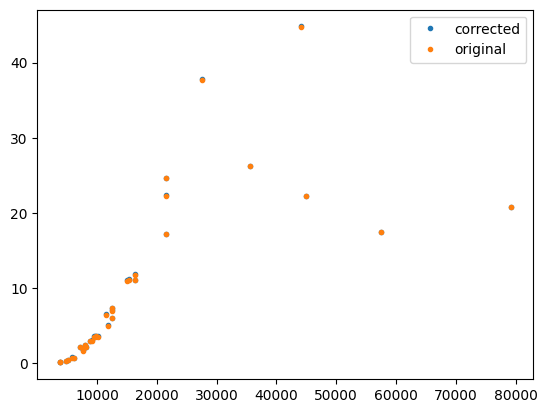

In [28]:
import matplotlib.pyplot as plt
waves, fluxes = load_pivot_wave('ellipse_v1'), load_fluxes('ellipse_v1')
plt.plot(waves, new_fluxes, '.', label='corrected')
plt.plot(waves, fluxes, '.', label='original')
plt.legend()
plt.show()

In [31]:
(new_fluxes/fluxes).max(), (new_fluxes/fluxes).min()

(1.0633381631490126, 1.0005851219231636)

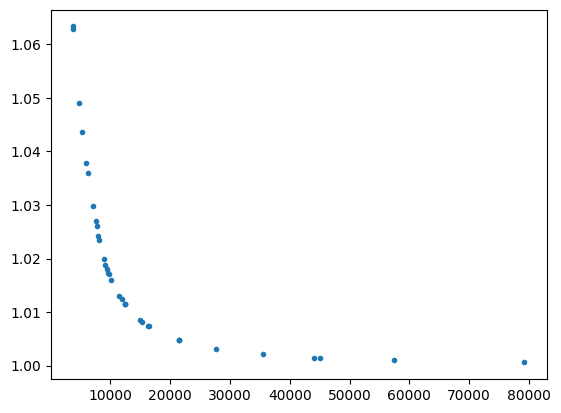

In [29]:
plt.plot(waves, new_fluxes/fluxes, '.')

In [35]:
def save_file(version, new_fluxes, copy_error=True):
    stack_df = pd.read_csv(f'/home/lupengjun/OII_emitter/photometry/output/flux_sum_{version}.csv', index_col=0).stack().reset_index()
    filters = stack_df['level_0']
    telescopes = stack_df['level_1']
    df_dic = {}
    for telescope, band, new_flux in zip(telescopes, filters, new_fluxes):
        if telescope not in df_dic.keys():
            df_dic[telescope] = {}
        df_dic[telescope][band] = new_flux
    df = pd.DataFrame(df_dic)
    df.to_csv(f'/home/lupengjun/OII_emitter/photometry/output/flux_sum_{version}_dered.csv')
    if copy_error:
        error_df = pd.read_csv(f'/home/lupengjun/OII_emitter/photometry/output/error_sum_{version}.csv', index_col=0)
        error_df.to_csv(f'/home/lupengjun/OII_emitter/photometry/output/error_sum_{version}_dered.csv')


In [37]:
for version in ['homo_ellipse_v1', 'space_homo_upright', 'space_homo_downleft']:
    new_fluxes = correct_redden(source_position, version)
    save_file(version, new_fluxes)

/tmp/ipykernel_2818979/3764247563.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return remove(ccm89(waves, Av, 3.1), fluxes)

/tmp/ipykernel_2818979/3764247563.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return remove(ccm89(waves, Av, 3.1), fluxes)

/tmp/ipykernel_2818979/3764247563.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return remove(ccm89(waves, Av, 3.1), fluxes)

